In [1]:
import os
import glob
import joblib
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from scipy.stats import zscore
from os.path import join as pjoin
from sklearn.decomposition import PCA
from utils import get_roi_data, save_ciftifile, conv2_labels, save2cifti

In [2]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
corr_path = os.path.join(wk_dir, 'build/featurewise-corr')
voxel_mask_path = os.path.join(wk_dir, 'prep/voxel_masks/')

subs = [f'sub-0{i+1}' for i in list(range(9))]
bmaskname = 'subjvis'
layername = 'googlenet-conv2'
modelname = 'RFmodels'

mask_name = 'primaryvis-in-MMP'
voxel_mask_nii = nib.load(os.path.join(voxel_mask_path, f'nod-voxmask_{mask_name}.dlabel.nii'))
voxel_mask = np.squeeze(voxel_mask_nii.get_fdata())
voxel_indices = np.where(voxel_mask==1)[0]

# generate specific ROI
v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxel_indices])
v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxel_indices])
v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxel_indices])

sharing_repeats = nib.load(os.path.join(voxel_mask_path, 'nod-voxmask_gmmret-in-subj-repeats.dscalar.nii')).get_fdata()
mask_gmm = nib.load(os.path.join(voxel_mask_path, 'nod-voxmask_gmmret-in-subj.dlabel.nii')).get_fdata()
mask_fix = nib.load(os.path.join(voxel_mask_path, 'nod-voxmask_fixret-in-subj.dlabel.nii')).get_fdata()
np.unique(sharing_repeats), mask_gmm.shape

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), (9, 59412))

In [29]:
indexname = 'full-model-ev-train'

dots_color = {'full-model-r':'#00CEE0', 'full-model-r-train':'#00838F',
              'full-model-ev':'#F96E46', 'full-model-ev-train':'#ECB009',}
cor_path = os.path.join(wk_dir, 'build/featurewise-corr')
model_folders = ['', 'singlesig', 'doublesig']
model_performance = {}
for model_folder in model_folders:
    modelcor_path = os.path.join(cor_path, model_folder)
    filepattern =os.path.join(modelcor_path, f"sub-*/*{indexname}.npy")
    files = glob.glob(filepattern)
    cors = []
    files = sorted(files)
    for file in files:
        corr = np.load(file)
        cors.append(corr)
        # print(file.split('/')[-1], ':', np.nanmin(corr), np.nanmax(corr))
        # print(file.split('/')[-1], ':', corr.shape)
    model_performance[model_folder] = np.stack(cors, axis=0)

    print(model_performance[model_folder].shape)

(9, 1, 59412)
(9, 1, 59412)
(9, 1, 59412)


In [5]:
import scipy.stats as stats
show_roi = v1_voxels

# model_folders = ['', 'doublesig', 'singlesig']

data1 = model_performance[''][:,0,show_roi].reshape(-1)
data2 = model_performance['doublesig'][:,0,show_roi].reshape(-1)
notnan_vertex = list(set(np.where(np.isnan(data1)==0)[0]) & set(np.where(np.isnan(data2)==0)[0]))
# 执行配对t检验
t_stat, p_value = stats.ttest_rel(data1[np.array(notnan_vertex)], data2[np.array(notnan_vertex)])

# 输出结果
print("t-statistic:", t_stat)
print("p-value:", p_value)

for isub, sub in enumerate(subs):

    sig_roi = show_roi #np.array([_ for _ in show_roi if _ in np.where(fullmodel_sig[isub]==1)[0]]) 

    data1 = corrs[isub,0,sig_roi].reshape(-1)
    data2 = ctrlcors[isub,0,sig_roi].reshape(-1)
    notnan_vertex = list(set(np.where(np.isnan(data1)==0)[0]) & set(np.where(np.isnan(data2)==0)[0]))
    # 执行配对t检验
    t_stat, p_value = stats.ttest_rel(data1[np.array(notnan_vertex)], data2[np.array(notnan_vertex)])

    # 输出结果
    print(sub, "t-statistic:", t_stat)
    print(sub, "p-value:", p_value)
    print("----------------------")

t-statistic: -15.68983187459753
p-value: 4.978292708932759e-55
sub-01 t-statistic: 8.17484226326392
sub-01 p-value: 5.894582027540633e-16
----------------------
sub-02 t-statistic: -11.791998856889226
sub-02 p-value: 7.440784940858002e-31
----------------------
sub-03 t-statistic: -6.2672521333583635
sub-03 p-value: 4.695472151597709e-10
----------------------
sub-04 t-statistic: -11.191147820271018
sub-04 p-value: 4.637941751617357e-28
----------------------
sub-05 t-statistic: -12.576274708576912
sub-05 p-value: 1.1057312185984542e-34
----------------------
sub-06 t-statistic: -3.9952242445163866
sub-06 p-value: 6.751842770740351e-05
----------------------
sub-07 t-statistic: -1.4300410904602683
sub-07 p-value: 0.1528973433291668
----------------------
sub-08 t-statistic: -9.418242868170342
sub-08 p-value: 1.5136817517519257e-20
----------------------
sub-09 t-statistic: 0.4807154610795452
sub-09 p-value: 0.6307833732410766
----------------------


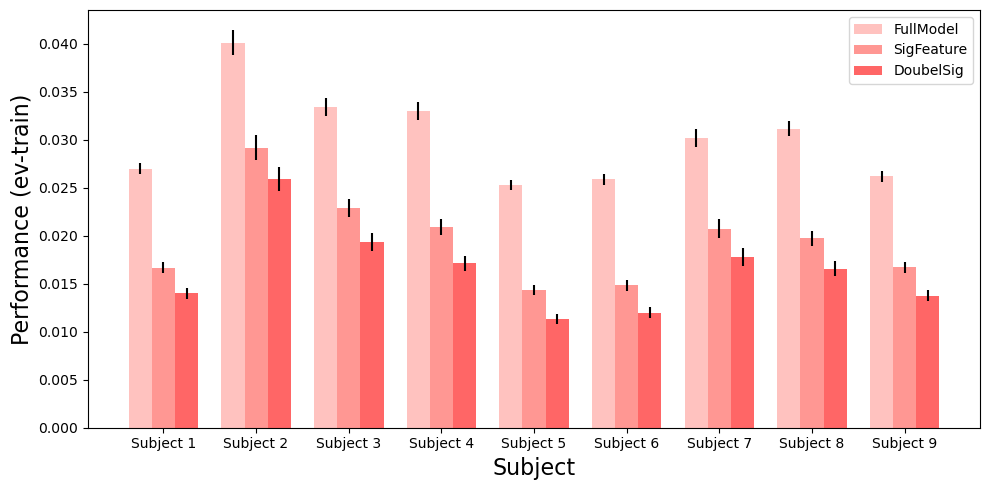

In [30]:
# 示例数据：9个被试，3种模型
n_subjects = 9
n_models = 3

show_roi = v1_voxels

# 每个被试在每种模型下的数据
performance = np.zeros((n_subjects, n_models)) # 平均性能
errors = np.zeros((n_subjects, n_models)) # 误差数据
model_folders = ['', 'singlesig', 'doublesig']
for i, model_folder in enumerate(model_folders): 
    performance[:,i] = np.nanmean(model_performance[model_folder][:,0,show_roi],axis=1)
    errors[:,i] = 1.96 * np.nanstd(model_performance[model_folder][:,0,show_roi],axis=1) / np.sqrt(len(show_roi))

# 模型名称和颜色
models = ['FullModel', 'SigFeature', 'DoubelSig']
colors = ["#ffc2bf","#ff9793","#ff6666"]#['red', 'blue']

# 绘制条形图
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10,5))

# 为每个模型生成条形图
bar_width = 0.25  # 条形的宽度
for i in range(n_models):
    # 计算每个条形的位置
    indices = np.arange(n_subjects) + i * bar_width
    # 绘制条形图
    ax.bar(indices, performance[:, i], bar_width, label=models[i], color=colors[i], yerr=errors[:, i])

# 设置图表标题和标签
ax.set_xlabel('Subject', fontsize=16)
indexlabel = indexname.replace('full-model-', '')
ax.set_ylabel(f'Performance ({indexlabel})', fontsize=16)
# ax.set_title('Average Performance of Each Model per Subject')
ax.set_xticks(np.arange(n_subjects) + bar_width)
ax.set_xticklabels(['Subject {}'.format(i+1) for i in range(n_subjects)], fontsize=10)

ax.legend(fontsize=10)
plt.tight_layout()
# 显示图表
plt.show()

In [34]:
(performance[:,1] / performance[:,0]), performance[:,2] / performance[:,0]

(array([0.61825573, 0.72677222, 0.68530633, 0.63420767, 0.56595542,
        0.57349487, 0.68776179, 0.6332381 , 0.63707985]),
 array([0.51860645, 0.64552023, 0.57780755, 0.51882312, 0.44793282,
        0.46377087, 0.59056744, 0.53221848, 0.52478974]))